# Classifiers - low vs mid vs high complexity - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
# required for the contractive autoencoder
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution()
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.multiclass import OneVsRestClassifier

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
#         if cog_res['task_complexity'][task_num_table] == 'medium':
#             continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }

        
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with standard scaler
phase_all_train = scale(phase_all_train, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with standard scaler
phase_all_valid = scale(phase_all_valid, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 256
epochs = 2000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='sigmoid', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='linear', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

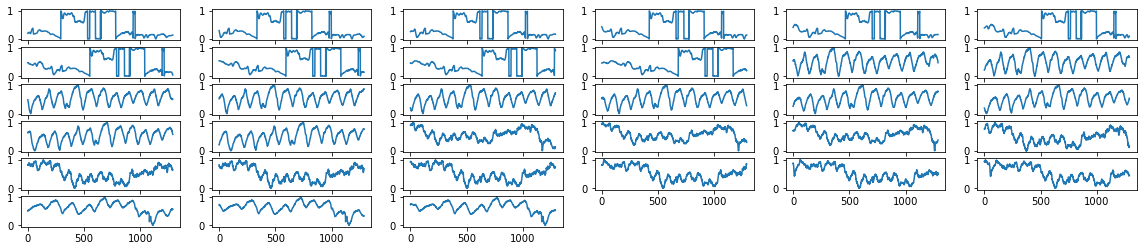

<Figure size 432x288 with 0 Axes>

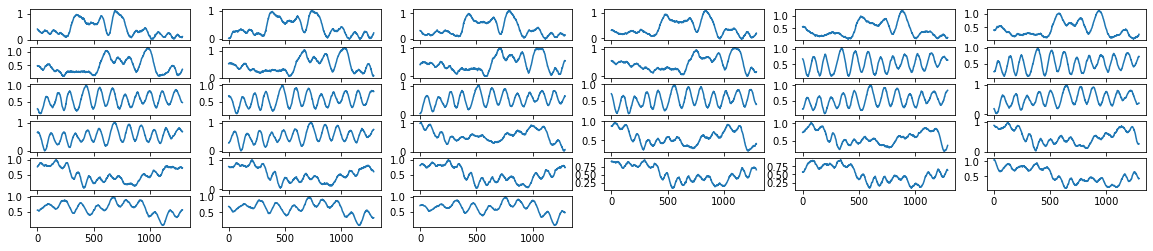

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

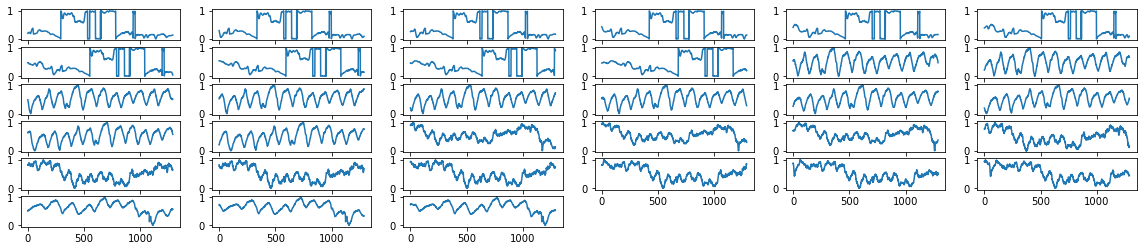

<Figure size 432x288 with 0 Axes>

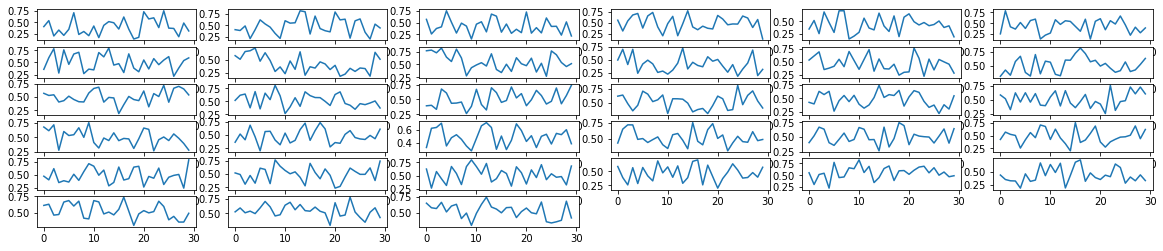

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [23]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:

                    # scale phase in a different way than other features
                    if (index == 1): 
                        # Scale each row with standard scaler
                        train_x = scale(train_x, axis=1)
                        valid_x = scale(valid_x, axis=1)
                        test_x = scale(test_x, axis=1)
                        # Scale each row with MinMax to range [0,1]
                        train_x = MinMaxScaler().fit_transform(train_x.T).T
                        valid_x = MinMaxScaler().fit_transform(valid_x.T).T
                        test_x = MinMaxScaler().fit_transform(test_x.T).T
                    else:
                        # Scale with standard scaler
                        sscaler = StandardScaler()
                        sscaler.fit(train_x)
                        train_x = sscaler.transform(train_x)

                        # Scale with MinMax to range [0,1]
                        mmscaler = MinMaxScaler((0,1))
                        mmscaler.fit(train_x)
                        train_x = mmscaler.transform(train_x)

                        # Scale valid and test with train's scalers
                        valid_x = sscaler.transform(valid_x)
                        valid_x = mmscaler.transform(valid_x)

                        test_x = sscaler.transform(test_x)
                        test_x = mmscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [24]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [25]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(3))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [26]:
accs = helper_loop(dense_train, idents, n=n, num_loops_to_average_over=1, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.007979
iteration: 2 of 23 ; time elapsed: 0:00:18.924690
iteration: 3 of 23 ; time elapsed: 0:00:37.730249
iteration: 4 of 23 ; time elapsed: 0:00:56.542892
iteration: 5 of 23 ; time elapsed: 0:01:15.935160
iteration: 6 of 23 ; time elapsed: 0:01:35.446743
iteration: 7 of 23 ; time elapsed: 0:01:55.148967
iteration: 8 of 23 ; time elapsed: 0:02:14.899654
iteration: 9 of 23 ; time elapsed: 0:02:34.522721
iteration: 10 of 23 ; time elapsed: 0:02:55.013965
iteration: 11 of 23 ; time elapsed: 0:03:15.636375
iteration: 12 of 23 ; time elapsed: 0:03:36.134108
iteration: 13 of 23 ; time elapsed: 0:03:56.795515
iteration: 14 of 23 ; time elapsed: 0:04:17.709174
iteration: 15 of 23 ; time elapsed: 0:04:38.837594
iteration: 16 of 23 ; time elapsed: 0:05:00.189613
iteration: 17 of 23 ; time elapsed: 0:05:21.671091
iteration: 18 of 23 ; time elapsed: 0:05:43.470402
iteration: 19 of 23 ; time elapsed: 0:06:05.551140
iteration: 20 of 23 ; time elapsed: 0:06

In [27]:
accuracies['simple_dense'] = accs

In [28]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.305556,0.300000,62i9y
1,0.377778,0.361111,2gu87
2,0.394444,0.311111,iz2ps
3,0.327778,0.322222,1mpau
4,0.288889,0.338889,7dwjy
5,0.288889,0.294444,7swyk
6,0.488889,0.383333,94mnx
7,0.433333,0.266667,bd47a
8,0.311111,0.322222,c24ur
9,0.277778,0.250000,ctsax


In [29]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.250000     0.250000
max     0.488889     0.422222
mean    0.333092     0.337440
median  0.305556     0.338889


#### LSTM-based classifier  
based on the original author's code

In [30]:
params_phase = {
    'kernel_size': 4,
    'filters': 64,
    'strides': 4,
    'pool_size': 4,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 128,
    'epochs': 100
}

In [31]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 8,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [32]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(3))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [33]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.006980
iteration: 2 of 23 ; time elapsed: 0:03:49.833389
iteration: 3 of 23 ; time elapsed: 0:07:40.698254
iteration: 4 of 23 ; time elapsed: 0:11:35.465920
iteration: 5 of 23 ; time elapsed: 0:15:32.986949
iteration: 6 of 23 ; time elapsed: 0:19:36.386215
iteration: 7 of 23 ; time elapsed: 0:23:40.495034
iteration: 8 of 23 ; time elapsed: 0:27:46.835104
iteration: 9 of 23 ; time elapsed: 0:31:54.624148
iteration: 10 of 23 ; time elapsed: 0:36:02.399360
iteration: 11 of 23 ; time elapsed: 0:40:12.395439
iteration: 12 of 23 ; time elapsed: 0:44:48.917083
iteration: 13 of 23 ; time elapsed: 0:49:28.681363
iteration: 14 of 23 ; time elapsed: 0:54:11.168140
iteration: 15 of 23 ; time elapsed: 0:59:07.567923
iteration: 16 of 23 ; time elapsed: 1:04:01.669102
iteration: 17 of 23 ; time elapsed: 1:08:54.110536
iteration: 18 of 23 ; time elapsed: 1:13:50.542616
iteration: 19 of 23 ; time elapsed: 1:18:51.621585
iteration: 20 of 23 ; time elapsed: 1:24

In [34]:
accuracies['LSTM'] = accs

In [35]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.501852,0.666667,62i9y
1,0.646296,0.666667,2gu87
2,0.579630,0.666667,iz2ps
3,0.603704,0.666667,1mpau
4,0.598148,0.666667,7dwjy
5,0.568519,0.666667,7swyk
6,0.566667,0.666667,94mnx
7,0.616667,0.666667,bd47a
8,0.542593,0.666667,c24ur
9,0.566667,0.666667,ctsax


In [36]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.479630     0.666667
max     0.646296     0.666667
mean    0.573108     0.666667
median  0.579630     0.666667


#### kNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [38]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(KNN_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [39]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.006980
iteration: 2 of 23 ; time elapsed: 0:00:00.651829
iteration: 3 of 23 ; time elapsed: 0:00:01.292686
iteration: 4 of 23 ; time elapsed: 0:00:01.922067
iteration: 5 of 23 ; time elapsed: 0:00:02.540110
iteration: 6 of 23 ; time elapsed: 0:00:03.175068
iteration: 7 of 23 ; time elapsed: 0:00:03.797486
iteration: 8 of 23 ; time elapsed: 0:00:04.414851
iteration: 9 of 23 ; time elapsed: 0:00:05.019769
iteration: 10 of 23 ; time elapsed: 0:00:05.648034
iteration: 11 of 23 ; time elapsed: 0:00:06.272359
iteration: 12 of 23 ; time elapsed: 0:00:06.924590
iteration: 13 of 23 ; time elapsed: 0:00:07.563923
iteration: 14 of 23 ; time elapsed: 0:00:08.180275
iteration: 15 of 23 ; time elapsed: 0:00:08.811587
iteration: 16 of 23 ; time elapsed: 0:00:09.438825
iteration: 17 of 23 ; time elapsed: 0:00:10.059166
iteration: 18 of 23 ; time elapsed: 0:00:10.681660
iteration: 19 of 23 ; time elapsed: 0:00:11.322425
iteration: 20 of 23 ; time elapsed: 0:00

In [40]:
accuracies['kNN'] = accs

In [41]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.311111,0.344444,62i9y
1,0.350000,0.383333,2gu87
2,0.355556,0.361111,iz2ps
3,0.350000,0.516667,1mpau
4,0.366667,0.338889,7dwjy
5,0.283333,0.361111,7swyk
6,0.338889,0.338889,94mnx
7,0.438889,0.322222,bd47a
8,0.327778,0.288889,c24ur
9,0.294444,0.288889,ctsax


In [42]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.183333     0.261111
max     0.533333     0.516667
mean    0.342754     0.333816
median  0.338889     0.333333


####  SVC

In [43]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [44]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(SVC_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [45]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=1)

iteration: 1 of 23 ; time elapsed: 0:00:00.007948
iteration: 2 of 23 ; time elapsed: 0:00:56.426640
iteration: 3 of 23 ; time elapsed: 0:01:53.037415
iteration: 4 of 23 ; time elapsed: 0:02:49.551193
iteration: 5 of 23 ; time elapsed: 0:03:46.009806
iteration: 6 of 23 ; time elapsed: 0:04:42.948693
iteration: 7 of 23 ; time elapsed: 0:05:40.450751
iteration: 8 of 23 ; time elapsed: 0:06:37.913333
iteration: 9 of 23 ; time elapsed: 0:07:34.566570
iteration: 10 of 23 ; time elapsed: 0:08:31.060138
iteration: 11 of 23 ; time elapsed: 0:09:27.644020
iteration: 12 of 23 ; time elapsed: 0:10:24.425224
iteration: 13 of 23 ; time elapsed: 0:11:20.181798
iteration: 14 of 23 ; time elapsed: 0:12:16.229596
iteration: 15 of 23 ; time elapsed: 0:13:12.400305
iteration: 16 of 23 ; time elapsed: 0:14:08.955057
iteration: 17 of 23 ; time elapsed: 0:15:05.760798
iteration: 18 of 23 ; time elapsed: 0:16:01.973681
iteration: 19 of 23 ; time elapsed: 0:16:58.268172
iteration: 20 of 23 ; time elapsed: 0:17

In [46]:
accuracies['SVC'] = accs

In [47]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.277778,0.244444,62i9y
1,0.438889,0.322222,2gu87
2,0.311111,0.300000,iz2ps
3,0.322222,0.344444,1mpau
4,0.266667,0.255556,7dwjy
5,0.300000,0.344444,7swyk
6,0.461111,0.505556,94mnx
7,0.461111,0.388889,bd47a
8,0.350000,0.200000,c24ur
9,0.416667,0.255556,ctsax


In [48]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.211111     0.200000
max     0.500000     0.505556
mean    0.345411     0.324638
median  0.338889     0.333333


#### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [50]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(random_forest_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [51]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=1, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006982
iteration: 2 of 23 ; time elapsed: 0:01:03.117895
iteration: 3 of 23 ; time elapsed: 0:02:06.057953
iteration: 4 of 23 ; time elapsed: 0:03:12.560393
iteration: 5 of 23 ; time elapsed: 0:04:18.045857
iteration: 6 of 23 ; time elapsed: 0:05:18.895272
iteration: 7 of 23 ; time elapsed: 0:06:22.765170
iteration: 8 of 23 ; time elapsed: 0:07:29.356120
iteration: 9 of 23 ; time elapsed: 0:08:32.786108
iteration: 10 of 23 ; time elapsed: 0:09:35.812091
iteration: 11 of 23 ; time elapsed: 0:10:41.738469
iteration: 12 of 23 ; time elapsed: 0:11:46.025386
iteration: 13 of 23 ; time elapsed: 0:12:55.793153
iteration: 14 of 23 ; time elapsed: 0:14:04.739488
iteration: 15 of 23 ; time elapsed: 0:15:07.545871
iteration: 16 of 23 ; time elapsed: 0:16:09.871027
iteration: 17 of 23 ; time elapsed: 0:17:16.701120
iteration: 18 of 23 ; time elapsed: 0:18:25.639250
iteration: 19 of 23 ; time elapsed: 0:19:35.136139
iteration: 20 of 23 ; time elapsed: 0:20

In [52]:
accuracies['random_forest'] = accs

In [53]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.344444,0.400000,62i9y
1,0.283333,0.272222,2gu87
2,0.388889,0.361111,iz2ps
3,0.522222,0.433333,1mpau
4,0.294444,0.355556,7dwjy
5,0.188889,0.300000,7swyk
6,0.455556,0.361111,94mnx
7,0.361111,0.366667,bd47a
8,0.227778,0.200000,c24ur
9,0.388889,0.283333,ctsax


In [54]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.188889     0.200000
max     0.522222     0.472222
mean    0.355072     0.344444
median  0.366667     0.355556


#### Naive Bayesian

In [55]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [56]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(naive_bayesian_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [57]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.008978
iteration: 2 of 23 ; time elapsed: 0:00:00.435863
iteration: 3 of 23 ; time elapsed: 0:00:00.894613
iteration: 4 of 23 ; time elapsed: 0:00:01.322741
iteration: 5 of 23 ; time elapsed: 0:00:01.805450
iteration: 6 of 23 ; time elapsed: 0:00:02.229491
iteration: 7 of 23 ; time elapsed: 0:00:02.711199
iteration: 8 of 23 ; time elapsed: 0:00:03.145038
iteration: 9 of 23 ; time elapsed: 0:00:03.614326
iteration: 10 of 23 ; time elapsed: 0:00:04.092448
iteration: 11 of 23 ; time elapsed: 0:00:04.518822
iteration: 12 of 23 ; time elapsed: 0:00:04.987566
iteration: 13 of 23 ; time elapsed: 0:00:05.410473
iteration: 14 of 23 ; time elapsed: 0:00:05.878984
iteration: 15 of 23 ; time elapsed: 0:00:06.306813
iteration: 16 of 23 ; time elapsed: 0:00:06.786072
iteration: 17 of 23 ; time elapsed: 0:00:07.220377
iteration: 18 of 23 ; time elapsed: 0:00:07.700603
iteration: 19 of 23 ; time elapsed: 0:00:08.136437
iteration: 20 of 23 ; time elapsed: 0:00

In [58]:
accuracies['naive_bayesian'] = accs

In [59]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.300000,0.294444,62i9y
1,0.405556,0.327778,2gu87
2,0.311111,0.350000,iz2ps
3,0.472222,0.277778,1mpau
4,0.383333,0.405556,7dwjy
5,0.333333,0.350000,7swyk
6,0.627778,0.300000,94mnx
7,0.255556,0.283333,bd47a
8,0.333333,0.311111,c24ur
9,0.372222,0.155556,ctsax


In [60]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.188889     0.155556
max     0.627778     0.405556
mean    0.351691     0.310145
median  0.333333     0.311111


#### XGBoost

In [61]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [62]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(XGBoost_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [63]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=1, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.008976
iteration: 2 of 23 ; time elapsed: 0:00:41.080353
iteration: 3 of 23 ; time elapsed: 0:01:20.869129
iteration: 4 of 23 ; time elapsed: 0:01:58.315392
iteration: 5 of 23 ; time elapsed: 0:02:36.983036
iteration: 6 of 23 ; time elapsed: 0:03:15.374036
iteration: 7 of 23 ; time elapsed: 0:03:53.323288
iteration: 8 of 23 ; time elapsed: 0:04:32.396203
iteration: 9 of 23 ; time elapsed: 0:05:11.476902
iteration: 10 of 23 ; time elapsed: 0:05:50.408556
iteration: 11 of 23 ; time elapsed: 0:06:29.428766
iteration: 12 of 23 ; time elapsed: 0:07:07.934382
iteration: 13 of 23 ; time elapsed: 0:07:45.994492
iteration: 14 of 23 ; time elapsed: 0:08:24.554536
iteration: 15 of 23 ; time elapsed: 0:09:01.781284
iteration: 16 of 23 ; time elapsed: 0:09:39.674791
iteration: 17 of 23 ; time elapsed: 0:10:17.407440
iteration: 18 of 23 ; time elapsed: 0:10:54.394620
iteration: 19 of 23 ; time elapsed: 0:11:31.259944
iteration: 20 of 23 ; time elapsed: 0:12

In [64]:
accuracies['XGBoost'] = accs

In [65]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.394444,0.366667,62i9y
1,0.233333,0.277778,2gu87
2,0.316667,0.316667,iz2ps
3,0.511111,0.466667,1mpau
4,0.277778,0.350000,7dwjy
5,0.250000,0.266667,7swyk
6,0.377778,0.288889,94mnx
7,0.333333,0.333333,bd47a
8,0.261111,0.222222,c24ur
9,0.377778,0.288889,ctsax


In [66]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.205556     0.222222
max     0.511111     0.466667
mean    0.341546     0.334058
median  0.338889     0.344444


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [67]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.250000     0.250000
max     0.488889     0.422222
mean    0.333092     0.337440
median  0.305556     0.338889


----------- LSTM: -----------
           phase  contractive
min     0.479630     0.666667
max     0.646296     0.666667
mean    0.573108     0.666667
median  0.579630     0.666667


----------- kNN: -----------
           phase  contractive
min     0.183333     0.261111
max     0.533333     0.516667
mean    0.342754     0.333816
median  0.338889     0.333333


----------- SVC: -----------
           phase  contractive
min     0.211111     0.200000
max     0.500000     0.505556
mean    0.345411     0.324638
median  0.338889     0.333333


----------- random_forest: -----------
           phase  contractive
min     0.188889     0.200000
max     0.522222     0.472222
mean    0.355072     0.344444
median  0.366667     0.355556


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [68]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.305556     0.300000   62i9y
1   0.377778     0.361111   2gu87
2   0.394444     0.311111   iz2ps
3   0.327778     0.322222   1mpau
4   0.288889     0.338889   7dwjy
5   0.288889     0.294444   7swyk
6   0.488889     0.383333   94mnx
7   0.433333     0.266667   bd47a
8   0.311111     0.322222   c24ur
9   0.277778     0.250000   ctsax
10  0.327778     0.361111   dkhty
11  0.294444     0.377778   e4gay
12  0.305556     0.422222   ef5rq
13  0.266667     0.350000   f1gjp
14  0.366667     0.333333   hpbxa
15  0.305556     0.338889   pmyfl
16  0.283333     0.333333   r89k1
17  0.266667     0.350000   tn4vl
18  0.338889     0.405556   td5pr
19  0.455556     0.322222   gyqu9
20  0.250000     0.361111   fzchw
21  0.261111     0.272222   l53hg
22  0.444444     0.383333   3n2f9


LSTM:
       phase  contractive test id
0   0.501852     0.666667   62i9y
1   0.646296     0.666667   2gu87
2   0.579630     0.666667   iz2ps
3   0.603704     0.666667 